# Sensing for Drones

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S73_drone_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.drone import axes

> Most drones use inertial sensing and cameras.

<img src="Figures7/S73-Autonomous_camera_drone-01.jpg" alt="Splash image with steampunk drone sporting an oversized IMU" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

## Inertial Measurement Units

```{index} pair: inertial measurement unit; IMU
```
```{index} sensing; inertial
```

An **inertial measurement unit** or **IMU** measures how a rigid body moves through space. The technological development of IMUs has undergone revolutionary transformations since their invention. Whereas they were initially developed for military and later civilian navigation purposes, miniaturized (MEMS) versions of them are now built into most of the mobile computing devices people use every day. IMUs often bundle the following three sensors: gyroscopes, accelerometers, and magnetometers, which we discuss in turn below.

### Gyroscopes

```{index} gyroscope
```
A **gyroscope** measures *changes* in orientation around three orthogonal axes, i.e., an angular velocity $\omega$.
This is useful for drones, as they fly in 3D space and have to carefully control and hence measure their attitude $R^n_b$. Gyroscopes do not directly measure attitude however, only the *rate of change* in orientation, and hence we need to integrate the angular velocity $\omega(t)$ over time:
\begin{equation}
R^n_b(t) = R^n_b(0) \int_{\tau=0}^t \exp \hat{\omega}(\tau) d\tau
\end{equation}
Above, the exponential map $\exp \hat{\omega}(\tau)$ is as defined in the previous section, where we have also shown how to numerically integrate forward in rotation space.

```{index} bias, drift
```
Unfortunately, when the gyroscope measurements are corrupted by random noise, this noise is also integrated over time. In addition, gyroscopes also suffer from **bias**, a non-zero offset of the measurements that changes slowly over time. If we know this bias, e.g., by estimating it, then we can subtract it first. However, if we do *not* know the bias, the resulting error grows linearly over time when it is integrated.

Both effects mean that we will gradually lose track of the correct attitude $R^n_b(t)$, a process known as *drift*.
Good (expensive) gyroscopes are able to track the attitude for a long time, whereas cheaper (MEMS) gyroscopes,
such as those found in many drones (and phones), can drift away from a usable attitude estimate in 100's or even 10's of seconds.

### Accelerometers

```{index} accelerometer
```
An **accelerometer** measures linear acceleration in 3D. While GPS can provide a measurement of the absolute position $r^n(t)$ of a drone, provided one is outdoors and in an open area, the errors associated with GPS are often large. Accelerometers are much more precise, but unfortunately do not provide absolute position: because they measure *forces* exerted upon them, any measurement they provide is essentially an acceleration, i.e., the second derivative of position. Hence, of course, the name "accelerometer".

In theory, we can *doubly* integrate the measured acceleration to obtain the position $r^n(t)$
(velocity is the integral of acceleration, and position is the integral of velocity).
However, because of the double integration, the effect of random noise and bias error is doubly compounded, making the use of an accelerometer for estimating a drone's position rather tricky. It can be done, but it requires great care and careful estimation of the biases. In fact, aircraft equipped with *inertial navigation systems* typically have an "INS alignment procedure" where the aircraft remains stationary on the taxi-way for a short period prior to take-off. Even then, unless the accelerometer can be augmented with absolute sources of position, such as GPS, an INS is bound to diverge sooner or later.

One of the most frequent and dependable uses of an accelerometer is to "aid" a gyroscope, maintaining absolute orientation over time.
As discussed above, integrating the angular velocity $\omega(t)$ over time accumulates error.
Because gravity is such a strong signal it often dwarfs the accelerations due to maneuvering, and hence we can use it to correct our attitude estimate (i.e., our estimate for the rotation matrix $R^n_b$). This is known as "aiding" the gyroscope. Note that the attitude has *three* degrees of freedom, and the accelerometer can only correct two of them: pitch and roll. The absolute heading of the drone is still unavailable.

### Magnetometers

```{index} magnetometer
```
A **magnetometer** measures a 3D vector that points along Earth's local magnetic field.
The magnetic field roughly points to the magnetic north, although it really is 3-dimensional, and magnetometers measure the strength of this field in all three axes. For drones, it is often a noisy and rather unreliable sensor, especially indoors or in the presence of metal structures, including electrical wiring etc. One drone application is inspecting bridges, and one can see that in such cases a magnetometer's usefulness will be rather limited.

Still, as a magnetometer functions like a sophisticated compass, its main use is to "aid" the gyroscope, providing a measurement on the absolute heading, i.e., the last remaining degree of freedom. While noisy, over time it can provide enough signal to recover and maintain the heading of the drone.

## Cameras

```{index} sensing; stereo
```

The second frequently used sensor for drones is a camera, or multiple cameras. Cameras are light-weight, cheap, and they provide some amazing capabilities, which we will discuss below and in the next section. They are also *passive*, in that unlike LIDAR sensors, they do not send out energy into the environment. This has obvious benefits in terms of stealth, important in some applications, but also is less power-hungry. In drones, battery autonomy is one of the key design constraints, and cameras are a very popular sensor for that reason alone.

```{index} visual odometry, localization, visual SLAM, extrinsic calibration
```
By tracking features in the image(s) over time, cameras can provide relative motion measurements, i.e., **visual odometry**. Given a preexisting map of the environment, a camera can be used to perform *localization*, providing absolute orientation and position even without an IMU. *If* an IMU is available it can be used to track the high frequency *relative* motion of the drone, while the visual information provides a lower frequency but *absolute* measurement of the drone's pose. In that way, IMU and camera measurements are perfectly complementary. In addition, if no map is available, cameras can be used to build a 3D map of the environment in real time, using a paradigm called **visual SLAM**, which we will discuss below.

In this section, about the raw sensing, we will concentrate on the **extrinsic calibration** of cameras and camera rigs. 
We have already discussed cameras as sensors in section 5.2, including their *intrinsic* calibration parameters such as focal length, image center, etc.
However, when using cameras on a drone, it is important to know the relative position and orientation of the camera with respect to the drone's body frame, the so called *extrinsic calibration parameters*, consisting of a position $t^b_c$ and orientation $R^b_c$ of the camera in the body frame.

We first need to specify the *position* of the camera(s) on the drone. 
Recall that the drone *body coordinate frame* is forward-left-up (FLU), and hence this is how we need to think about where the camera is:
a camera towards the front of the drone will have a positive $X$ value, etc. Below is a simple example with two cameras in front and one towards the back of the drone:

In [ ]:
t1 = gtsam.Point3(0.1, 0.05, 0.01) # front-left
t2 = gtsam.Point3(0.1,-0.05, 0.01) # front-right
t3 = gtsam.Point3(-0.1, 0, 0.01) # back

We can visualize the camera placement in the drone's FLU body frame using `plotly`, as shown in Figure [1](#fig:camera-locations).

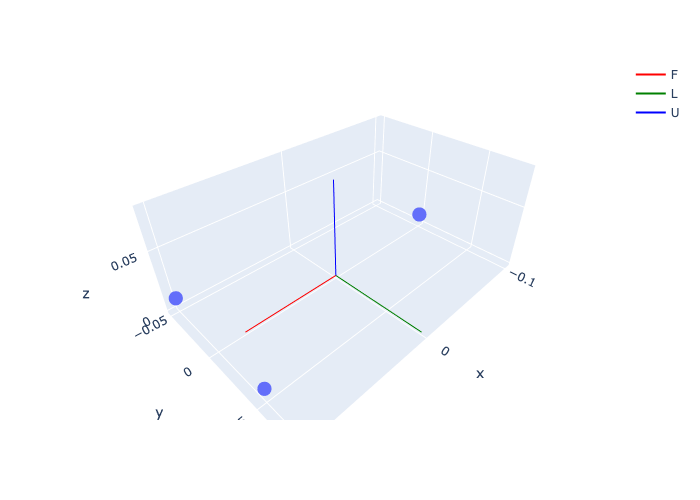

In [ ]:
#| caption: The three camera pinhole locations in the FLU frame.
#| label: fig:camera-locations
fig = px.scatter_3d(x=[t1[0], t2[0], t3[0]], y=[t1[1], t2[1], t3[1]], z=[t1[2], t2[2], t3[2]])
fig.add_traces(axes(gtsam.Pose3(), scale=0.08, labels=["F","L","U"])) # add FLU drone body frame
fig.update_yaxes(scaleanchor = "x", scaleratio = 1);
fig.show()

To specify the *orientation* $R^b_c$ for each of the cameras, we need to remember that (a) the $z$-axis points into the scene, and (b) the $y$-axis points down. The easiest way to specify this is by using the `Rot3` constructor that takes three column vectors:

In [ ]:
F,L,U = np.eye(3)
bTc1 = gtsam.Pose3(gtsam.Rot3(-L,-U,F), t1)
bTc2 = gtsam.Pose3(gtsam.Rot3(-L,-U,F), t2)
bTc3 = gtsam.Pose3(gtsam.Rot3(L,-U,-F), t3)

Try to understand the code above, which made camera 1 and 2 look forward ($F$), creating a *forward-looking stereo pair*, and camera 3 look backwards ($-F$). The other axes were then specified to have the images upright. 
We can again use the `gtbook.drones.axes` function to ease displaying this with `plotly`, in Figure [2](#fig:camera-frames).
Especially for visual odometry, which we will cover in the next section, having both forward and backward looking cameras is a good idea, yielding high quality estimates of the drone's rotation. Cameras pointed to the side will often suffer from motion blur in forward flight mode, especially with close obstacles at high speed.

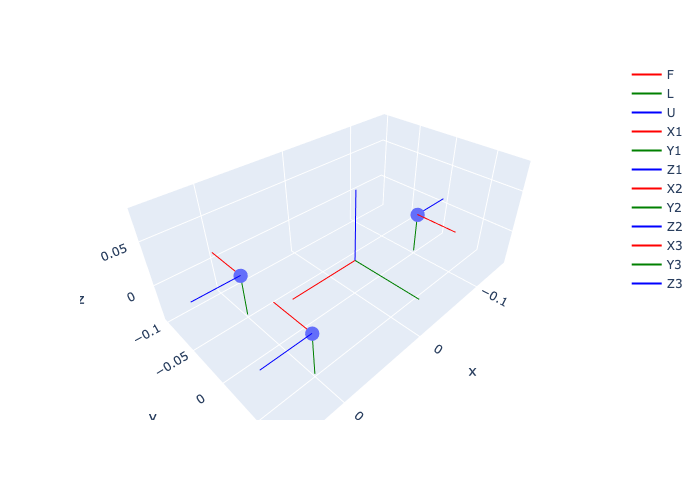

In [ ]:
#| caption: The camera coordinate frames in the FLU frame.
#| label: fig:camera-frames
fig.add_traces(axes(bTc1, scale=0.05, labels=["X1","Y1","Z1"]))
fig.add_traces(axes(bTc2, scale=0.05, labels=["X2","Y2","Z2"]))
fig.add_traces(axes(bTc3, scale=0.05, labels=["X3","Y3","Z3"]))
fig.show()

## Projecting 3D Points

> Transforming coordinates into the right reference frame.

We have seen in Chapter 5 how to project points specified in the *camera* frame onto the image plane. However, for visual SLAM - which we'll discuss at length in the next section - an additional step is needed: we need to transform the 3D points from the navigation frame into the camera frame. This involves both the camera extrinsics and the drone's pose $T^n_b$ in the navigation frame itself.

Let us start by reviewing the fundamental projection equation from chapter 5:

\begin{equation}
u = u_0 + f \frac{X^c}{Z^c} \,\,\,\, v = v_0 + f \frac{Y^c}{Z^c}.
\end{equation}
where $u_0$, $v_0$, and $f$ are the *intrinsic* camera calibration parameters, and $P^c=(X^c,Y^c,Z^c)$ are the coordinates of a 3D point in the *camera* coordinate frame, hence the superscript $C$. But what if we are given the 3D coordinates $P^n=(X^n,Y^n,Z^n)$ in the ENU navigation frame, rather than in the camera frame? Because the camera is mounted on the drone, we do this in two steps:

- convert from navigation to body frame: $P^b = (R^n_b)^T (P^n - d^n_b)$
- convert from body to camera frame: $P^c = (R^b_c)^T (P^b - d^b_c)$

where $T^n_b=(R^n_b,d^n_b)$ is the drone's FLU body pose with respect to the ENU navigation frame, and $T^b_c=(R^b_c,d^b_c)$ is the camera pose (i.e., the extrinsic camera parameters) specified in the body frame. In case there are multiple cameras the first conversion needs to be done only once, but the second conversion will be camera specific.

## A Stereo Example in Code

> It all works, folks!

As an example, let us assume the drone is at position $t^n_b=(100, 300, 10)$ (i.e., 10 meters high)
and flying north:

In [ ]:
E,N,U = np.eye(3)
ntb = gtsam.Point3(100, 300, 10)
nRb = gtsam.Rot3(N,-E,U) # flying north, left of drone facing west
nTb = gtsam.Pose3(nRb, ntb)

Let's project a point $P^n=(103,310,12)$ 10 meters in front of the drone (check this!) into the stereo pair. We make use of the GTSAM method `Pose3.TransformTo` to convert from navigation to body (once) and then from body to camera (twice):

In [ ]:
nP = gtsam.Point3(103,310,12)
bP = nTb.transformTo(nP)
print(f"bP = {bP} in (F,L,U) body frame")
c1P = bTc1.transformTo(bP)
print(f"c1P = {c1P} in camera frame 1")
c2P = bTc2.transformTo(bP)
print(f"c2P = {c2P} in camera frame 2")

bP = [10. -3.  2.] in (F,L,U) body frame
c1P = [ 3.05 -1.99  9.9 ] in camera frame 1
c2P = [ 2.95 -1.99  9.9 ] in camera frame 2


As you can see, the point in body coordinates is $10m$ ahead, because the $x$-coordinate is $10$ in the FLU body frame. Moreover, the points expressed in the two forward-looking camera frames are identical *except* for the $x$ coordinates, which is exactly what we expect from a stereo rig. We can then apply the intrinsics to get the final image coordinates, for example using a $640\times 480$ image and a focal length of $300$:

In [ ]:
w, h, f = 640, 480, 300
u0, v0 = float(w/2), float(h/2)
u1, v1 = u0 + f * c1P[0]/c1P[2], v0 + f * c1P[1]/c1P[2]
print(f"u1,v1 = {np.round([u1,v1],2)} in image 1")
u2, v2 = u0 + f * c2P[0]/c2P[2], v0 + f * c2P[1]/c2P[2]
print(f"u2,v2 = {np.round([u2,v2],2)} in image 2")

u1,v1 = [412.42 179.7 ] in image 1
u2,v2 = [409.39 179.7 ] in image 2


Again, this is exactly what we expect for a stereo rig. In this case the disparity is $412.4-409.4\approx3$ pixels, and if we plug that into the fundamental stereo equation from Section 5.2, with baseline $10cm$ (check the extrinsics!), we indeed obtain that the point is at a depth of $10m$:
\begin{equation}
Z = B \frac{f}{d} = 0.1 \frac{300}{3} = 10
\end{equation}

In actuality, the disparity is a tiny bit larger, and if we plug in the exact number, we get the *true* depth from the camera center:

In [ ]:
print(f"disparity = {round(u1-u2,5)} pixels")
# and depth:
print(f"depth = {round(0.1 * f / (u1-u2),1)} meters")

disparity = 3.0303 pixels
depth = 9.9 meters
